# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import imageio
import os

from kernels import *
from sparse_gp import *

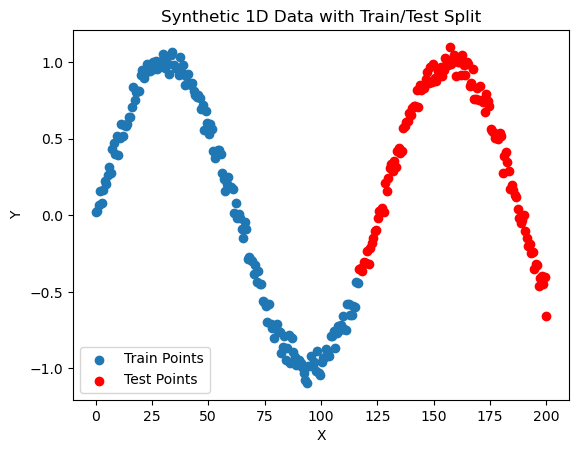

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Predictive Mean and Uncertainty Plot

In [3]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn):
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)
    numInducing = Z.shape[0]

    # Make predictions on the test set using the optimized hyperparameters
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays for plotting and ensure all are 1D
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()

    # Ensure all variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot the points, predictive mean, and confidence interval
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")

    # Plot predictive mean line and 95% confidence interval
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     (posterior_mean - 1.96 * onp.sqrt(posterior_var)),
                     (posterior_mean + 1.96 * onp.sqrt(posterior_var)),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title(f"Sparse GP Prediction with Uncertainty (Including {numInducing} Inducing Points)")
    plt.show()
#

### Negative Log Predictive Density Plot

In [4]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn, noise_variance):
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

### ELBO Plot

In [5]:
def plot_elbo(history):
    # Extract ELBO values and steps from history
    elbo_values = [entry["elbo"] for entry in history]
    steps = [entry["step"] for entry in history]
    
    # Plot the ELBO values over steps
    plt.figure(figsize=(10, 5))
    plt.plot(steps, elbo_values, label="ELBO", color='blue')
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training Steps")
    plt.legend()
    plt.show()
#

### Kernel Hyperparameter Plot

In [6]:
def plot_kernel_hyperparameters(history):
    # Extract training steps
    steps = [entry["step"] for entry in history]
    
    # Function to normalize values between 0 and 1
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) for v in values] if max_val > min_val else values

    # Extract and normalize raw hyperparameters
    weights_1 = normalize([entry["hyperparams"][0] for entry in history])
    weights_2 = normalize([entry["hyperparams"][1] for entry in history])
    weights_3 = normalize([entry["hyperparams"][2] for entry in history])
    noise_variance_sqexp = normalize([entry["hyperparams"][3] for entry in history])
    signal_variance_sqexp = normalize([entry["hyperparams"][4] for entry in history])
    length_scale_sqexp = normalize([entry["hyperparams"][5] for entry in history])
    noise_variance_linear = normalize([entry["hyperparams"][6] for entry in history])
    signal_variance_linear = normalize([entry["hyperparams"][7] for entry in history])
    noise_variance_matern = normalize([entry["hyperparams"][8] for entry in history])
    signal_variance_matern = normalize([entry["hyperparams"][9] for entry in history])
    length_scale_matern = normalize([entry["hyperparams"][10] for entry in history])
    nu_matern = normalize([entry["hyperparams"][11] for entry in history])
    noise_variance_sinusoidal = normalize([entry["hyperparams"][12] for entry in history])
    signal_variance_sinusoidal = normalize([entry["hyperparams"][13] for entry in history])
    period_sinusoidal = normalize([entry["hyperparams"][14] for entry in history])
    length_scale_sinusoidal = normalize([entry["hyperparams"][15] for entry in history])
    period_sinusoidal = normalize([entry["hyperparams"][16] for entry in history])

    # Plot normalized kernel hyperparameters
    plt.figure(figsize=(12, 8))

    # Plot for Squared-Exponential Kernel (Blue)
    plt.plot(steps, weights_1, label="Weight (Squared-Exponential Kernel)", color='blue', linestyle='--')
    # plt.plot(steps, noise_variance_sqexp, label="Noise Variance (Sq-Exp)", color='blue', linestyle='-.')
    plt.plot(steps, signal_variance_sqexp, label="Signal Variance (Sq-Exp)", color='blue', linestyle='-')
    plt.plot(steps, length_scale_sqexp, label="Length Scale (Sq-Exp)", color='blue', linestyle=':')

    # Plot for Linear Kernel (Red)
    plt.plot(steps, weights_2, label="Weight (Linear Kernel)", color='red', linestyle='--')
    # plt.plot(steps, noise_variance_linear, label="Noise Variance (Linear)", color='red', linestyle='-.')
    plt.plot(steps, signal_variance_linear, label="Signal Variance (Linear)", color='red', linestyle='-')

    # Plot for Matern Kernel (Green)
    plt.plot(steps, weights_3, label="Weight (Matern Kernel)", color='green', linestyle='--')
    # plt.plot(steps, noise_variance_matern, label="Noise Variance (Matern)", color='green', linestyle='-.')
    plt.plot(steps, signal_variance_matern, label="Signal Variance (Matern)", color='green', linestyle='-')
    plt.plot(steps, length_scale_matern, label="Length Scale (Matern)", color='green', linestyle=':')
    # plt.plot(steps, nu_matern, label="Nu (Matern)", color='green', linestyle='--')

    # Plot for Sinusoidal Kernel (Purple)
    plt.plot(steps, weights_3, label="Weight (Sinusoidal Kernel)", color='purple', linestyle='--')
    # plt.plot(steps, noise_variance_sinusoidal, label="Noise Variance (Sinusoidal)", color='purple', linestyle='-.')
    plt.plot(steps, signal_variance_sinusoidal, label="Signal Variance (Sinusoidal)", color='purple', linestyle='-')
    plt.plot(steps, length_scale_sinusoidal, label="Length Scale (Sinusoidal)", color='purple', linestyle=':')
    plt.plot(steps, period_sinusoidal, label="Period (Sinusoidal)", color='purple', linestyle='--')

    # Plot configuration
    plt.xlabel("Step")
    plt.ylabel("Normalized Parameter Value (0 to 1)")
    plt.title("Normalized Kernel Hyperparameter Values Over Training Steps")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [7]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Three initial weights in log space for unconstrained optimization
    initial_weights = [np.log(0.33), np.log(0.33), np.log(0.33)]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]  # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear + hyperparams_matern + hyperparams_sinusoidal
    return np.array(initial_params)
#

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [8]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -181.93872959952796
Step 10, ELBO: -166.7371634126785
Step 20, ELBO: -149.47334703302351
Step 30, ELBO: -109.48375567162783
Step 40, ELBO: -79.53129127164978
Step 50, ELBO: -52.925360074004374
Step 60, ELBO: -29.73669936404619
Step 70, ELBO: -11.419075968783517
Step 80, ELBO: 0.8529222531827543
Step 90, ELBO: 7.427645217706868
Step 100, ELBO: 10.182454945750607
Step 110, ELBO: 11.114110980953427
Step 120, ELBO: 11.387606061671846
Step 130, ELBO: 11.464808778507631
Step 140, ELBO: 11.489561148518277
Step 150, ELBO: 11.50095997580442
Step 160, ELBO: 11.508949923805687
Step 170, ELBO: 11.516014792337018
Step 180, ELBO: 11.52279172238238
Step 190, ELBO: 11.52945962873875
Optimized Hyperparameters: [7.00567494e-01 2.57035636e-01 3.17904214e-01 5.28635448e-03
 5.77072694e+00 3.88859386e+03 5.28960723e-03 2.11725848e+00
 5.28960723e-03 2.61864620e+00 2.20264444e+04 1.10517092e+00
 2.69025379e+00 2.20264531e+04 2.71824113e+00]
Final ELBO Value: 11.53541746832775


In [9]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 3 Weights:", np.sum(optimized_hyperparams[:3]))

Optimized Hyperparameters: [7.00567494e-01 2.57035636e-01 3.17904214e-01 5.28635448e-03
 5.77072694e+00 3.88859386e+03 5.28960723e-03 2.11725848e+00
 5.28960723e-03 2.61864620e+00 2.20264444e+04 1.10517092e+00
 2.69025379e+00 2.20264531e+04 2.71824113e+00]
sum of First 3 Weights: 1.2755073441693134


## Predict and Plot the Results

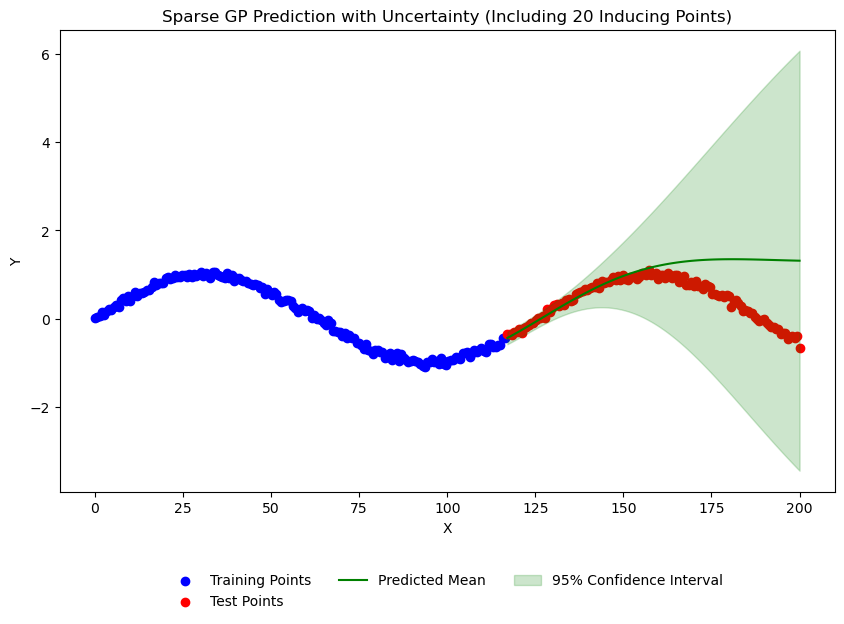

In [10]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [ ]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
# print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
# print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
# print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
# print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 54.92%
Kernel 2 (Linear): 20.15%
Kernel 3 (Matérn): 24.92%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0053
Kernel 1 - Signal Variance: 5.7707
Kernel 1 - Length Scale: 3888.5939
Kernel 2 - Noise Variance: 0.0053
Kernel 2 - Signal Variance: 2.1173
Kernel 3 - Noise Variance: 0.0053
Kernel 3 - Signal Variance: 2.6186
Kernel 3 - Length Scale: 22026.4444


## NLPD on Test Data

In [12]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.3581
Test NLPD: 1.3621


## ELBO Maximization

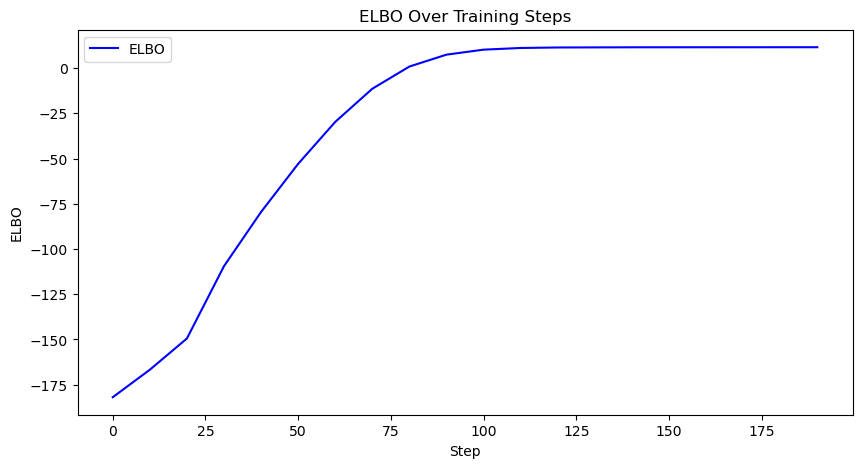

In [13]:
plot_elbo(history)

## Kernel Hyperparameters

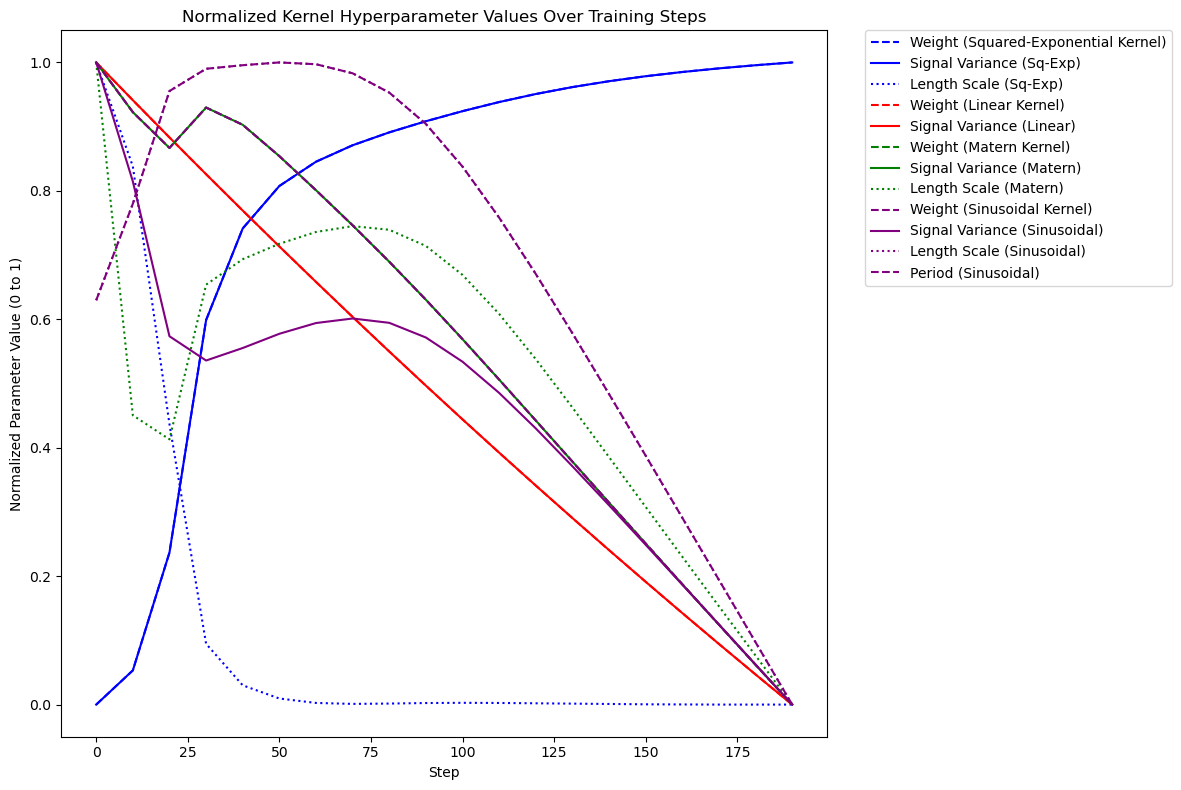

In [14]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [15]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [16]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -181.93864711455774
Step 10, ELBO: -166.73687233317756
Step 20, ELBO: -149.47314267503938
Step 30, ELBO: -109.48372020463759
Step 40, ELBO: -79.53138991999114
Step 50, ELBO: -52.92576599903849
Step 60, ELBO: -29.737432788516315
Step 70, ELBO: -11.41973447052294
Step 80, ELBO: 0.8533201374684438
Step 90, ELBO: 7.42999723003507
Step 100, ELBO: 10.186689713285944
Step 110, ELBO: 11.119481255062084
Step 120, ELBO: 11.39346754124037
Step 130, ELBO: 11.47084243104021
Step 140, ELBO: 11.495651407569511
Step 150, ELBO: 11.50707475035287
Step 160, ELBO: 11.515084461019882
Step 170, ELBO: 11.522171772998774
Step 180, ELBO: 11.528975439963318
Step 190, ELBO: 11.535674080996671
Optimized Hyperparameters: [7.01448395e-01 2.57035763e-01 3.17934327e-01 5.28467996e-03
 5.77798311e+00 3.90011855e+03 5.28792293e-03 2.11725952e+00
 5.28792293e-03 2.61889425e+00 2.20264324e+04 1.10517092e+00
 2.69025809e+00 2.20264649e+04 2.71827804e+00]
Final ELBO Value: 11.541662494802353


In [17]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [7.01448395e-01 2.57035763e-01 3.17934327e-01 5.28467996e-03
 5.77798311e+00 3.90011855e+03 5.28792293e-03 2.11725952e+00
 5.28792293e-03 2.61889425e+00 2.20264324e+04 1.10517092e+00
 2.69025809e+00 2.20264649e+04 2.71827804e+00]
sum of First 2 Weights: 0.9584841583795165


## Predict and Plot the Results

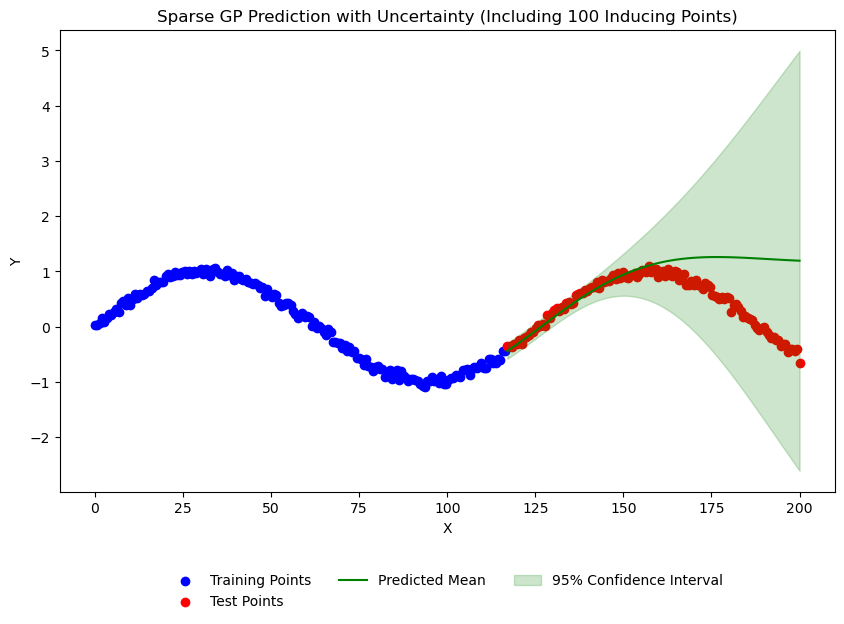

In [18]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [23]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
# print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
# print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
# print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
# print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 54.95%
Kernel 2 (Linear): 20.14%
Kernel 3 (Matérn): 24.91%
Kernel 4 (Sinusoidal): 24.91%

Other Hyperparameters:
Kernel 1 - Signal Variance: 5.7780
Kernel 1 - Length Scale: 3900.1186
Kernel 2 - Signal Variance: 2.1173
Kernel 3 - Signal Variance: 2.6189
Kernel 3 - Length Scale: 22026.4324
Kernel 4 - Signal Variance: 2.6903
Kernel 4 - Period: 22026.4649
Kernel 4 - Length Scale: 2.7183


## NLPD

In [20]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.3582
Test NLPD: 1.2022


## ELBO Maximization


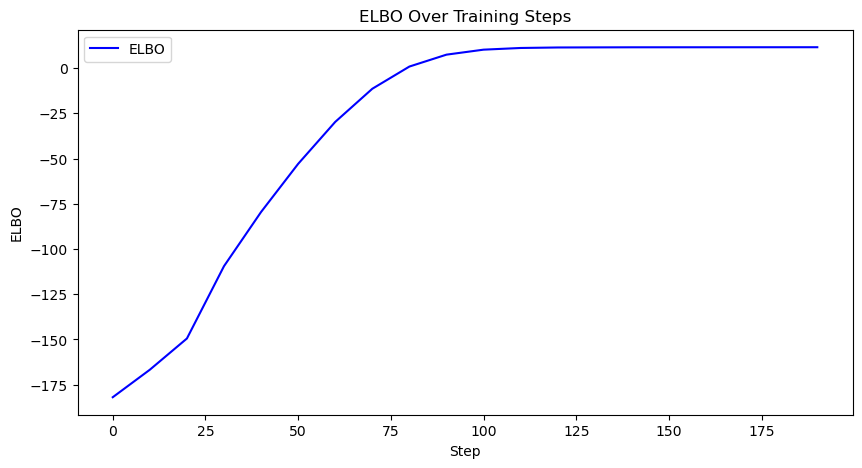

In [21]:
plot_elbo(history)

## Kernel Hyperparameters

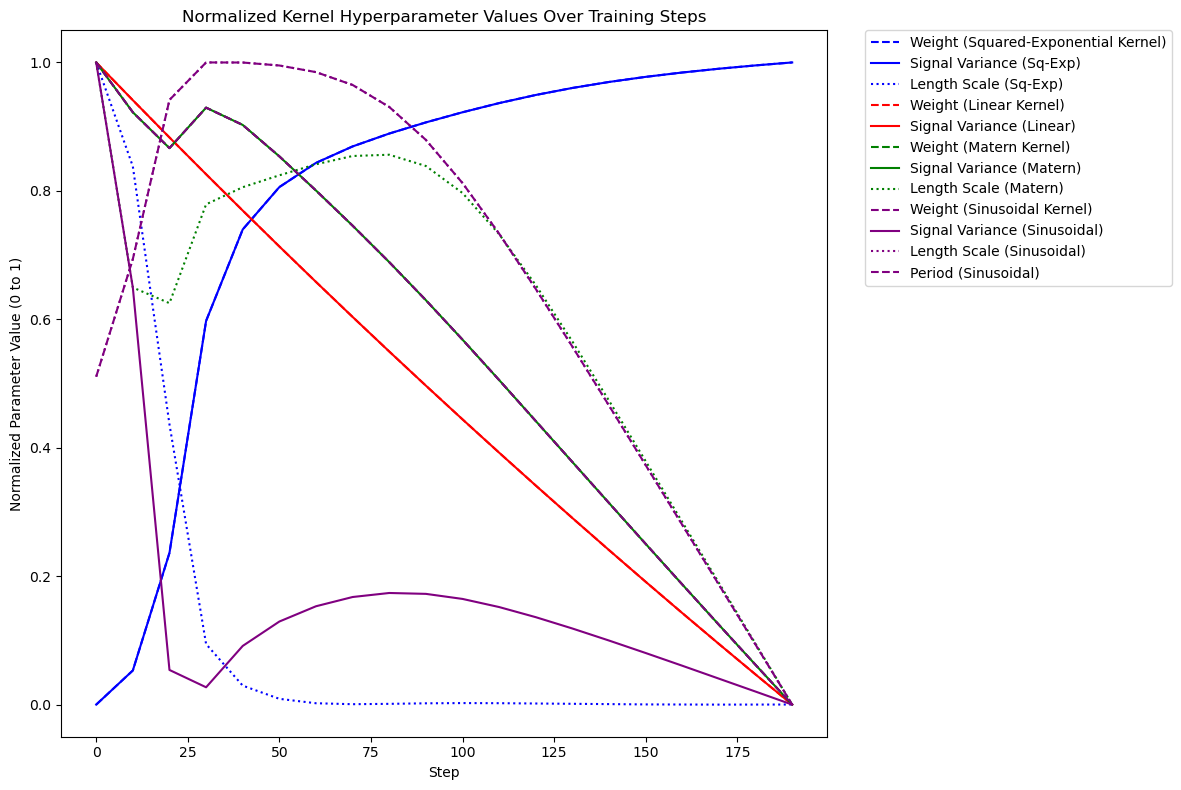

In [22]:
plot_kernel_hyperparameters(history)